# Analysing llama31 vs finetuned model:

In [1]:
import glob
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

In [2]:
MODEL_1 = "llama31"
MODEL_2 = "finetuned"

SET_1_PATH = "data/evaluation/midi/{}/*".format(MODEL_1)
SET_2_PATH = "data/evaluation/midi/{}/*".format(MODEL_2)

SET_1_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_1)
SET_2_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_2)

ABSOLUTE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/absolute_metrics_statistics.pkl".format(MODEL_1, MODEL_2)
RELATIVE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/relative_metrics_statistics.pkl".format(MODEL_1, MODEL_2)

## Absolute measurement: statistic analysis


Assign sample dataset path

In [3]:
set1 = glob.glob(SET_1_PATH)
print(set1)

['data/evaluation/midi/llama31/dialog_0_message_1.mid', 'data/evaluation/midi/llama31/dialog_36_message_1.mid', 'data/evaluation/midi/llama31/dialog_3_message_1.mid', 'data/evaluation/midi/llama31/dialog_65_message_1.mid', 'data/evaluation/midi/llama31/dialog_46_message_1.mid', 'data/evaluation/midi/llama31/dialog_48_message_1.mid', 'data/evaluation/midi/llama31/dialog_45_message_1.mid', 'data/evaluation/midi/llama31/dialog_29_message_1.mid']


Assign baseline dataset path

In [4]:
set2 = glob.glob(SET_2_PATH)
print(set2)

['data/evaluation/midi/finetuned/dialog_40_message_1.mid', 'data/evaluation/midi/finetuned/dialog_58_message_1.mid', 'data/evaluation/midi/finetuned/dialog_75_message_1.mid', 'data/evaluation/midi/finetuned/dialog_88_message_1.mid', 'data/evaluation/midi/finetuned/dialog_63_message_1.mid', 'data/evaluation/midi/finetuned/dialog_73_message_1.mid', 'data/evaluation/midi/finetuned/dialog_10_message_1.mid', 'data/evaluation/midi/finetuned/dialog_81_message_1.mid', 'data/evaluation/midi/finetuned/dialog_33_message_1.mid', 'data/evaluation/midi/finetuned/dialog_1_message_1.mid', 'data/evaluation/midi/finetuned/dialog_0_message_1.mid', 'data/evaluation/midi/finetuned/dialog_32_message_1.mid', 'data/evaluation/midi/finetuned/dialog_28_message_1.mid', 'data/evaluation/midi/finetuned/dialog_87_message_1.mid', 'data/evaluation/midi/finetuned/dialog_26_message_1.mid', 'data/evaluation/midi/finetuned/dialog_18_message_1.mid', 'data/evaluation/midi/finetuned/dialog_14_message_1.mid', 'data/evaluatio

### Build empty dictionary to fill in measurement across samples

In [5]:
num_samples = min(len(set2), len(set1))
display(num_samples)

8

In [6]:
def init_eval_dict(num_samples):
    return {
        # Pitch-based features
        'total_used_pitch': np.zeros((num_samples, 1)),
        'total_pitch_class_histogram': np.zeros((num_samples, 12)),
        'pitch_class_transition_matrix': np.zeros((num_samples, 12, 12)),
        'pitch_range': np.zeros((num_samples, 1)),
        'avg_pitch_shift': np.zeros((num_samples, 1)),
        # Rhythm-based features
        'total_used_note': np.zeros((num_samples, 1)),
        'avg_IOI': np.zeros((num_samples, 1)),
        'note_length_hist': np.zeros((num_samples, 12)),
        'note_length_transition_matrix': np.zeros((num_samples, 12, 12)),
    }

set1_eval = init_eval_dict(num_samples)
set2_eval = init_eval_dict(num_samples)

List of metrics to calculate

In [7]:
metrics_list = set1_eval.keys()

### Calculate absolute metrics

First dataset

In [8]:
for i in range(0, num_samples):
    feature = core.extract_feature(set1[i])
    for metric in metrics_list:
        set1_eval[metric][i] = getattr(core.metrics(), metric)(feature)

Write set1_eval calculated metrics

In [9]:
with open(SET_1_CALCULATED_METRICS_PATH, "wb") as f:
    pickle.dump(set1_eval, f)

Second dataset

In [10]:
for i in range(0, num_samples):
    feature = core.extract_feature(set2[i])
    for metric in metrics_list:
        set2_eval[metric][i] = getattr(core.metrics(), metric)(feature)

Write set2_eval calculated metrics

In [11]:
with open(SET_2_CALCULATED_METRICS_PATH, "wb") as f:
    pickle.dump(set2_eval, f)

Statistic analysis: absolute measurement

In [12]:
summary_stats = {}
for metric in metrics_list:
    set1_mean = np.mean(set1_eval[metric], axis=0)
    set1_std = np.std(set1_eval[metric], axis=0)
    set2_mean = np.mean(set2_eval[metric], axis=0)
    set2_std = np.std(set2_eval[metric], axis=0)
    summary_stats[metric] = {
        MODEL_1: {'mean': set1_mean.tolist(), 'std': set1_std.tolist()},
        MODEL_2: {'mean': set2_mean.tolist(), 'std': set2_std.tolist()}
    }

    print('------------------------------------------------------------------------------------------------')
    print('Metric: {}'.format(metric))
    print('{} => Mean: {}, Std: {}'.format(MODEL_1, set1_mean, set1_std))
    print('{} => Mean: {}, Std: {}'.format(MODEL_2, set2_mean, set2_std))
    print('------------------------------------------------------------------------------------------------\n')

------------------------------------------------------------------------------------------------
Metric: total_used_note
llama31 => Mean: [63.5], Std: [30.20761493]
finetuned => Mean: [133.125], Std: [58.64605166]
------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Metric: avg_pitch_shift
llama31 => Mean: [2.37220087], Std: [0.502449]
finetuned => Mean: [2.45293912], Std: [0.75430059]
------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Metric: note_length_transition_matrix
llama31 => Mean: [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.    29.5   11.625  0.     0.     0.

Write absolute metrics statistics

In [13]:
with open(ABSOLUTE_METRICS_STATISTICS_PATH, "wb") as f:
    pickle.dump(summary_stats, f)

## Relative measurement: generalizes the result among features with various dimensions


the features are sum- marized to 
- the intra-set distances
- the difference of intra-set and inter-set distances.

exhaustive cross-validation for intra-set distances measurement

In [14]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
set1_intra = np.zeros((num_samples, len(metrics_list), num_samples - 1))
set2_intra = np.zeros((num_samples, len(metrics_list), num_samples - 1))
for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        set1_intra[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set1_eval[metrics_list[i]][train_index])
        set2_intra[test_index[0]][i] = utils.c_dist(set2_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]][train_index])

exhaustive cross-validation for inter-set distances measurement

In [15]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]])

visualization of intra-set and inter-set distances

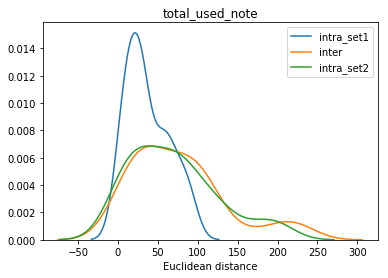

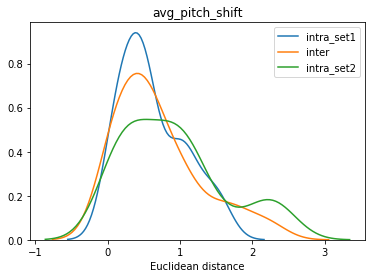

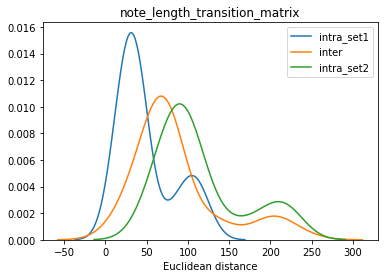

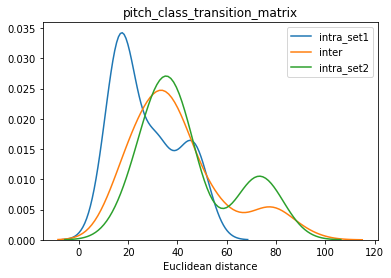

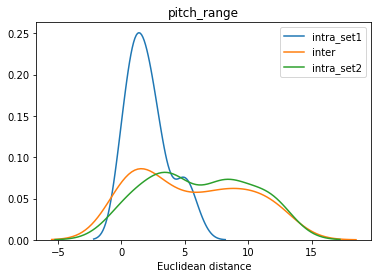

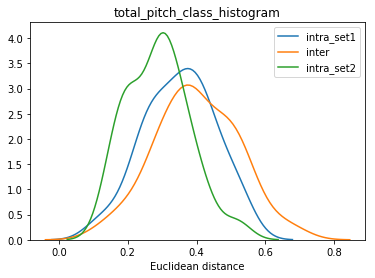

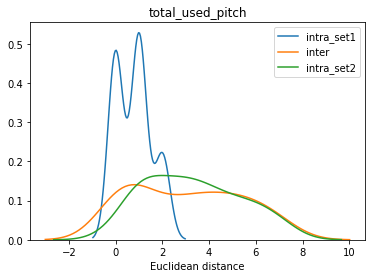

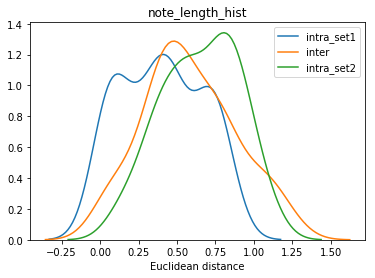

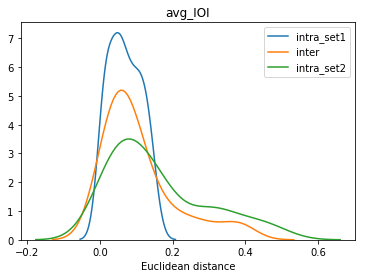

In [16]:
plot_set1_intra = np.transpose(set1_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_set2_intra = np.transpose(set2_intra,(1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter,(1, 0, 2)).reshape(len(metrics_list), -1)
for i in range(0,len(metrics_list)):
    sns.kdeplot(plot_set1_intra[i], label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], label='inter')
    sns.kdeplot(plot_set2_intra[i], label='intra_set2')

    plt.title(metrics_list[i])
    plt.xlabel('Euclidean distance')
    plt.show()

the difference of intra-set and inter-set distances.

In [17]:
relative_stats = {}
for i in range(0, len(metrics_list)):
    kl1 = utils.kl_dist(plot_set1_intra[i], plot_sets_inter[i])
    overlap1 = utils.overlap_area(plot_set1_intra[i], plot_sets_inter[i])
    kl2 = utils.kl_dist(plot_set2_intra[i], plot_sets_inter[i])
    overlap2 = utils.overlap_area(plot_set2_intra[i], plot_sets_inter[i])
    metric = metrics_list[i]
    relative_stats[metric] = {
        MODEL_1: {
            'kl_divergence': kl1,
            'overlap_area': overlap1
        },
        MODEL_2: {
            'kl_divergence': kl2,
            'overlap_area': overlap2
        }
    }
    print('------------------------------------------------------------------------------------------------')
    print('Metric: {}'.format(metric))
    print('{} => Kullback–Leibler divergence: {}, Overlap area: {}'.format(MODEL_1, kl1, overlap1))
    print('{} => Kullback–Leibler divergence: {}, Overlap area: {}'.format(MODEL_2, kl2, overlap2))
    print('------------------------------------------------------------------------------------------------\n')

------------------------------------------------------------------------------------------------
Metric: total_used_note
llama31 => Kullback–Leibler divergence: 0.0781115815421, Overlap area: 0.592438313619
finetuned => Kullback–Leibler divergence: 0.019086465831, Overlap area: 0.853255292875
------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Metric: avg_pitch_shift
llama31 => Kullback–Leibler divergence: 0.03506280967, Overlap area: 0.804803455881
finetuned => Kullback–Leibler divergence: 0.0284947370582, Overlap area: 0.753574858346
------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------
Metric: note_length_transition_matrix
llama31 => Kullback–Leibler divergence: 0.0449612383852, Overlap area: 0.570425452

Write relative metrics statistics

In [18]:
with open(RELATIVE_METRICS_STATISTICS_PATH, "wb") as f:
    pickle.dump(relative_stats, f)